<a href="https://colab.research.google.com/github/zahraa-elhareedy/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zahraaelhareedy","key":"b06530eec274d20cc26e527b0761f6a3"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Install the Kaggle API client
!pip install kaggle

# Download the CREMA dataset using the Kaggle API
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

# Unzip the dataset archive
!unzip speech-emotion-recognition-en.zip



Streaming output truncated to the last 5000 lines.
  inflating: Crema/1088_IWW_FEA_XX.wav  
  inflating: Crema/1088_IWW_HAP_XX.wav  
  inflating: Crema/1088_IWW_NEU_XX.wav  
  inflating: Crema/1088_IWW_SAD_XX.wav  
  inflating: Crema/1088_MTI_ANG_XX.wav  
  inflating: Crema/1088_MTI_DIS_XX.wav  
  inflating: Crema/1088_MTI_FEA_XX.wav  
  inflating: Crema/1088_MTI_HAP_XX.wav  
  inflating: Crema/1088_MTI_NEU_XX.wav  
  inflating: Crema/1088_MTI_SAD_XX.wav  
  inflating: Crema/1088_TAI_ANG_XX.wav  
  inflating: Crema/1088_TAI_DIS_XX.wav  
  inflating: Crema/1088_TAI_FEA_XX.wav  
  inflating: Crema/1088_TAI_HAP_XX.wav  
  inflating: Crema/1088_TAI_NEU_XX.wav  
  inflating: Crema/1088_TAI_SAD_XX.wav  
  inflating: Crema/1088_TIE_ANG_XX.wav  
  inflating: Crema/1088_TIE_DIS_XX.wav  
  inflating: Crema/1088_TIE_FEA_XX.wav  
  inflating: Crema/1088_TIE_HAP_XX.wav  
  inflating: Crema/1088_TIE_NEU_XX.wav  
  inflating: Crema/1088_TIE_SAD_XX.wav  
  inflating: Crema/1088_TSI_ANG_XX.wav  
  infl

In [ ]:
sampling_rate = 16000

In [ ]:
def load(data_path):
    files_names = os.listdir(data_path)
    dataset = {"audio_data": [] , "emotions": []}

    # Loop through each file in the subdirectory
    for file_name in files_names:
        file_path = os.path.join(data_path, file_name)

        # Load the audio file
        sound , sr = librosa.load(file_path, sr=sampling_rate)
        sound_len=len(sound)
        # Get the label from the file name
        emotion = file_name.split("_")[2]
        # Store the label, and audio data in the dataset
        dataset["emotions"].append(emotion)
        dataset["audio_data"].append(sound)
        
    return dataset

In [ ]:
def display_random_samples(dataset,n) :
  random_indices = np.random.choice(len(dataset["emotions"]),n, replace=False)
  emotions = [dataset["emotions"][i] for i in random_indices]
  audios = [dataset["audio_data"][i] for i in random_indices]
  for i in range(len(audios)):
    plt.figure(figsize=(8, 4))
    librosa.display.waveshow(audios[i], sr=sampling_rate)
    plt.title(f"Waveform for {emotions[i]} sample")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()
    # Play the audio
    display(Audio(audios[i], rate=sampling_rate))


In [ ]:
def time_stretch_augmentation(dataset):
   time_stretch_dataset = {"audio_data": [] , "emotions": []}
   random_indices = np.random.choice(len(dataset["emotions"]), 1500, replace=False)
   emotions = [dataset["emotions"][i] for i in random_indices]
   audios = [dataset["audio_data"][i] for i in random_indices]
   for i in range(len(audios)):
      stretch_factor = np.random.uniform(0.8, 1.2)
      audio_stretch = librosa.effects.time_stretch(audios[i], rate = stretch_factor)
      time_stretch_dataset["emotions"].append(emotions[i])
      time_stretch_dataset["audio_data"].append(audio_stretch) 
   return time_stretch_dataset

In [ ]:
def pitch_shift_augmentation(dataset):
   pitch_shift_dataset = {"audio_data": [] , "emotions": []}
   random_indices = np.random.choice(len(dataset["emotions"]), 1500, replace=False)
   emotions = [dataset["emotions"][i] for i in random_indices]
   audios = [dataset["audio_data"][i] for i in random_indices]
   for i in range(len(audios)):
      pitch_shift_factor = np.random.uniform(-4, 4)
      pitch_shifted_audio = librosa.effects.pitch_shift(audios[i], sr = sampling_rate, n_steps=pitch_shift_factor)
      pitch_shift_dataset["emotions"].append(emotions[i])
      pitch_shift_dataset["audio_data"].append(pitch_shifted_audio)
   return pitch_shift_dataset


In [ ]:
def fix_length(dataset, target_length):
    fixed_dataset = {"audio_data": [] , "emotions": []}
    
    for i,audio in enumerate(dataset["audio_data"]):
        audio_len = len(audio)
        
        # If audio is longer than target length, truncate
        if audio_len > target_length:
            fixed_dataset["audio_data"].append(audio[:target_length])
        # If audio is shorter than target length, pad with zeros
        else:
            padding_length = target_length - audio_len
            audio_padded = np.pad(audio, (0, padding_length))
            fixed_dataset["audio_data"].append(audio_padded)
        fixed_dataset["emotions"].append(dataset["emotions"][i])
    
    return fixed_dataset

In [ ]:
def check_audio_lengths(dataset,header):
    lengths = [len(audio) for audio in dataset[header]]
    if len(set(lengths)) == 1:
        print(f"All audios have length {lengths[0]}")
    else:
        print("Audios have different lengths")

In [ ]:
def get_average_length(dataset):
  total_length = 0
  num_audios = len(dataset["audio_data"])

  for audio in dataset["audio_data"]:
    audio_length = len(audio)
    total_length += audio_length

  average_length = total_length / num_audios
  return int(average_length)

In [ ]:
# Load the audio data and class labels from the dataset
dataset = load('/content/Crema')

In [ ]:
print(len(dataset["emotions"]))

7442


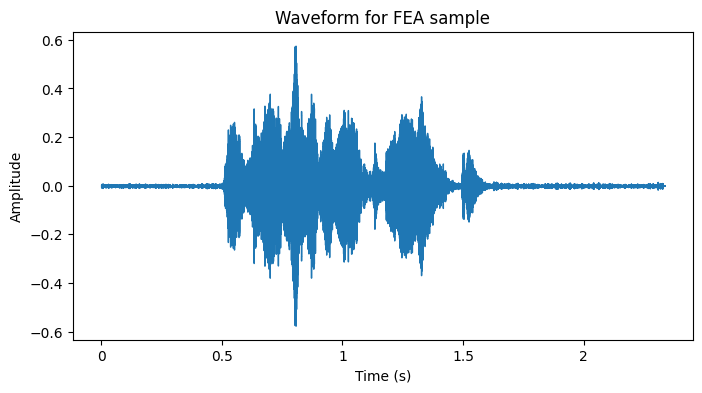

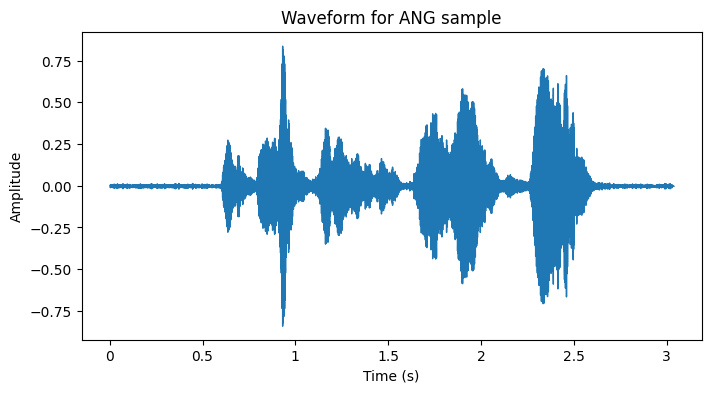

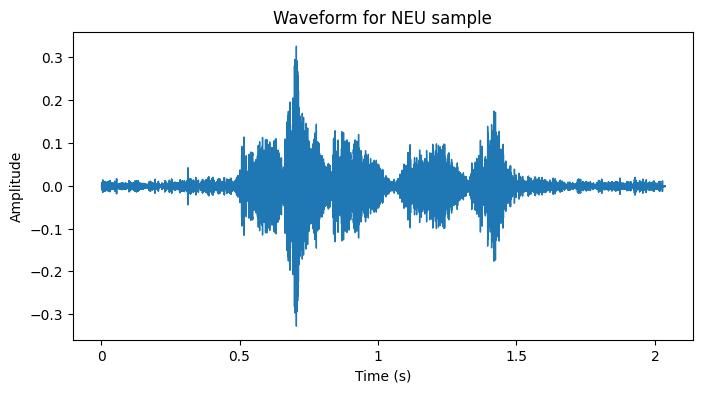

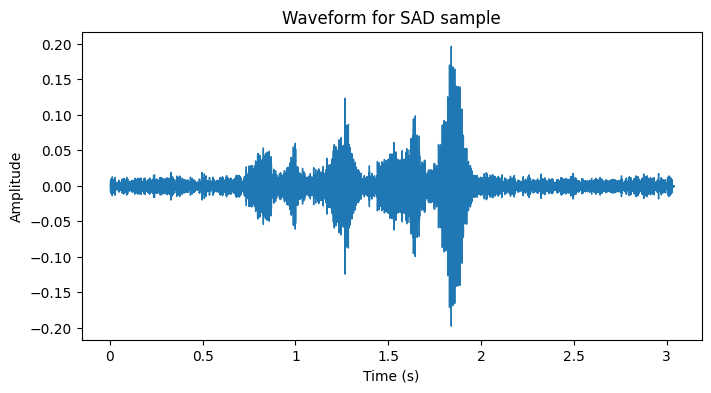

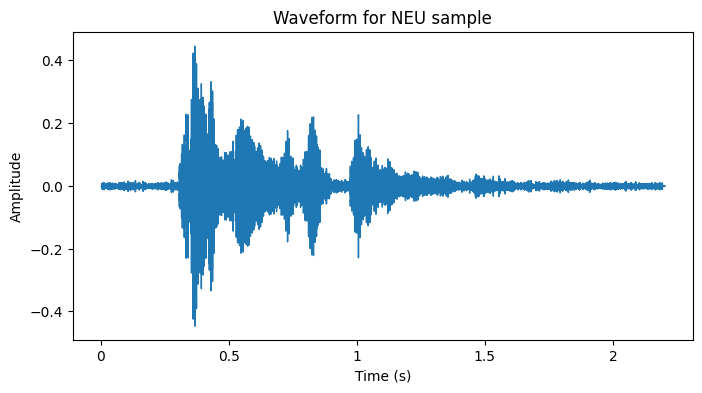

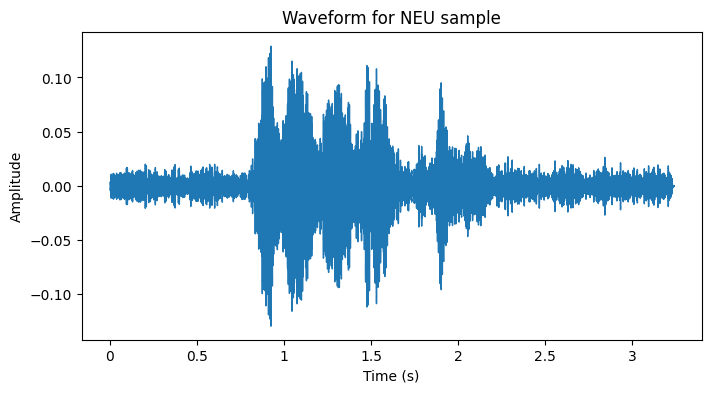

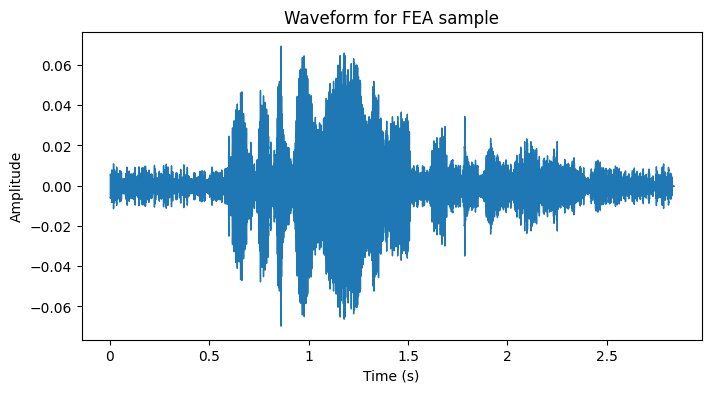

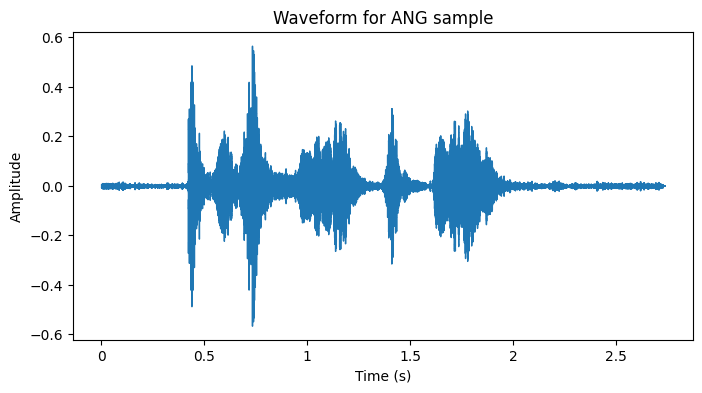

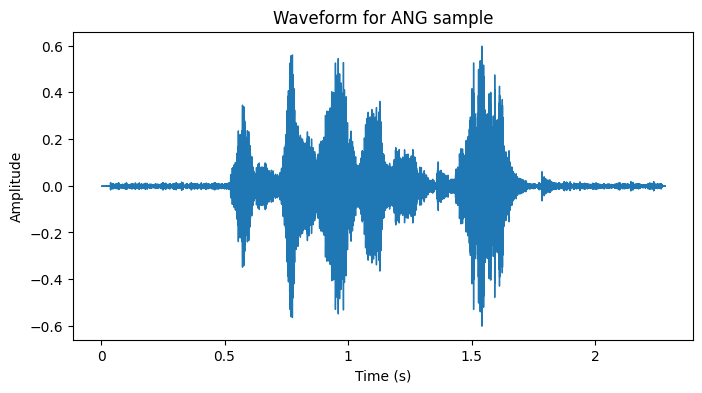

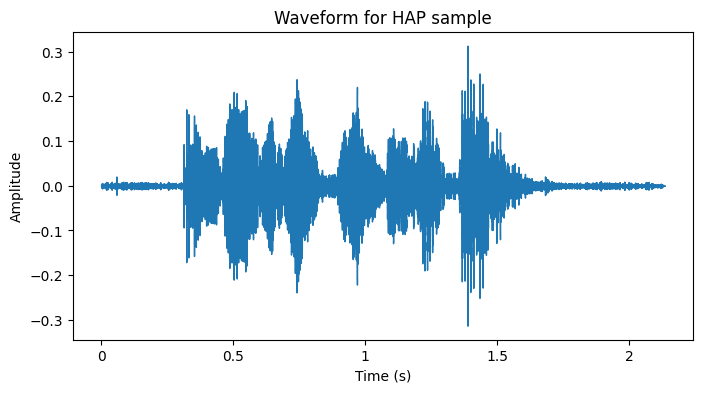

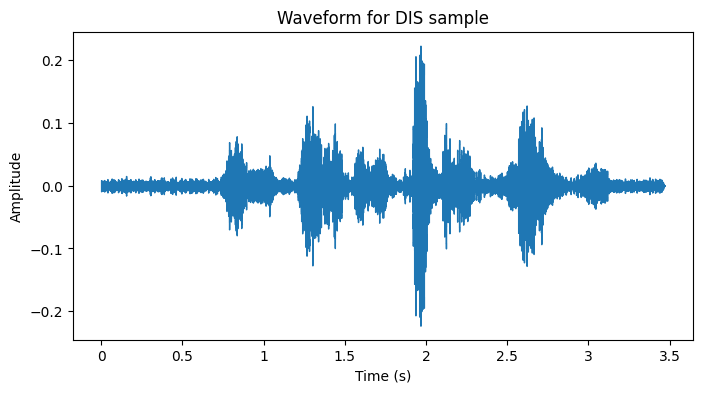

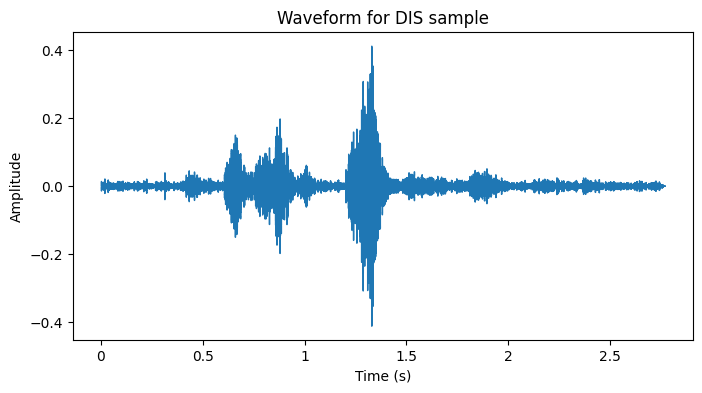

In [ ]:
display_random_samples(dataset,12)

Time stretched samples


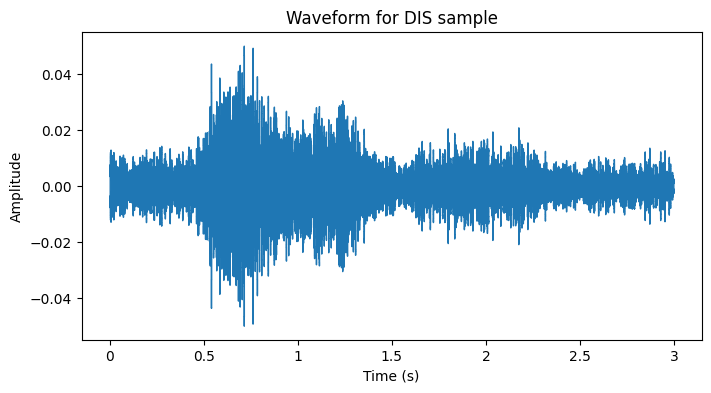

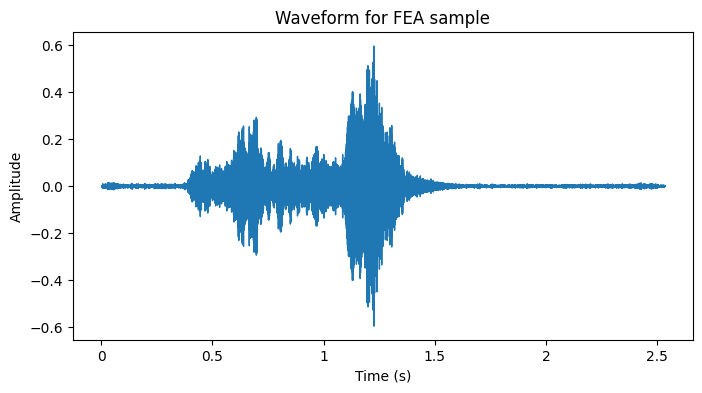

In [ ]:
time_stretch_dataset = time_stretch_augmentation(dataset)
print("Time stretched samples")
display_random_samples(time_stretch_dataset,2)

Pitch shifted samples


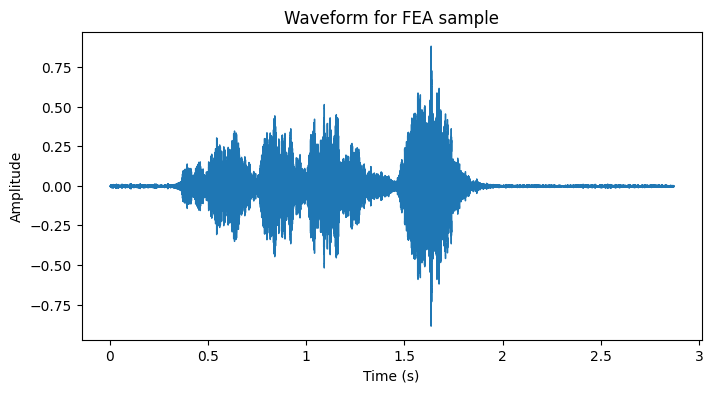

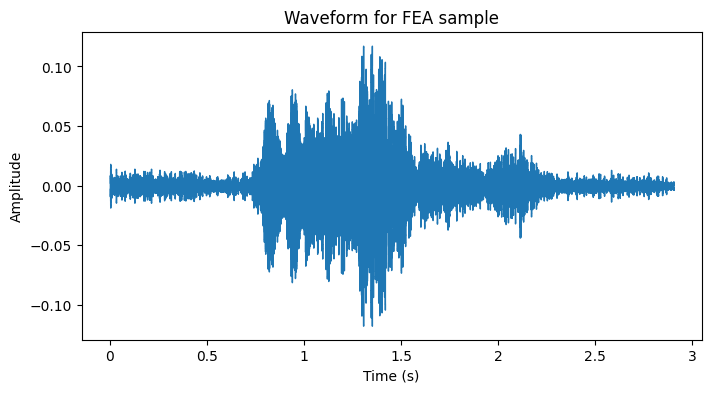

In [ ]:
pitch_shift_dataset = pitch_shift_augmentation(dataset)
print("Pitch shifted samples")
display_random_samples(pitch_shift_dataset,2)

In [ ]:
print(len(dataset["emotions"]))

7442


In [ ]:
for i in range (len(pitch_shift_dataset["emotions"])):
    dataset["emotions"].append(pitch_shift_dataset["emotions"][i])
    dataset["audio_data"].append(pitch_shift_dataset["audio_data"][i])
print(len(dataset["emotions"]))


8942


In [ ]:
for i in range (len(time_stretch_dataset["emotions"])):
    dataset["emotions"].append(time_stretch_dataset["emotions"][i])
    dataset["audio_data"].append(time_stretch_dataset["audio_data"][i])
print(len(dataset["emotions"]))

10442


In [ ]:
check_audio_lengths(dataset,"audio_data")
average_length = get_average_length(dataset)
print(average_length)
fixed_dataset = fix_length(dataset , average_length)
check_audio_lengths(fixed_dataset,"audio_data")

Audios have different lengths
40807
All audios have length 40807


In [ ]:
def get_first_factor(average_length,first,last):
  for num in range(first,last):
    if average_length%num == 0:
      return num
  return get_first_factor(average_length,last,last+5)

In [ ]:
num_frames = get_first_factor(average_length,15,25)
if num_frames:
  frame_size = average_length//num_frames
print(f"frame size {frame_size}")  
print(f"number of frames {num_frames}")  

frame size 949
number of frames 43


In [ ]:
def feature_space_1D(dataset , frame_size = frame_size,sampling_rate=16000): 
  feature_space_1D = {"zcr": [] , "energy" :[], "mfcc" :[], "spec_centroid" :[], "emotions": []}
  for i,audio in enumerate(dataset["audio_data"]):
     #zcr
     zcr = librosa.feature.zero_crossing_rate(audio, frame_length=frame_size, hop_length=int(frame_size/2))
     feature_space_1D["zcr"].append(zcr.flatten())
     #energy
     energy = librosa.feature.rms(y=audio, frame_length=frame_size , hop_length=int(frame_size/2))
     feature_space_1D["energy"].append(energy.flatten())
     #mfcc
     mfcc=librosa.feature.mfcc(y=audio,sr=sampling_rate,n_fft=frame_size,n_mfcc=13, hop_length=int(frame_size/2))#(13,No.of frames)
     feature_space_1D["mfcc"].append(mfcc.flatten())
     #spectral centroid
     spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=sampling_rate,n_fft=frame_size,hop_length=int(frame_size/2))
     feature_space_1D["spec_centroid"].append(spec_centroid.flatten())
     feature_space_1D["emotions"].append(dataset["emotions"][i])
  return feature_space_1D

In [ ]:
def feature_space_2D(dataset ,sampling_rate=16000, n_mels=128, n_fft=1569 , hop_length=512):
  feature_space_2D = {"mel_spectrogram": [] , "emotions": []}
  for i,audio in enumerate(dataset["audio_data"]):
      mel_spec = librosa.feature.melspectrogram(y=audio, sr=sampling_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
      # Convert mel spectrogram to log scale
      mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
      #mel_spec_3d = mel_spec_db.reshape(mel_spec_db.shape[0], mel_spec_db.shape[1], 1)
      #feature_space_2D["mel_spectrogram"].append(mel_spec_3d)
      feature_space_2D["mel_spectrogram"].append(mel_spec_db)
      feature_space_2D["emotions"].append(dataset["emotions"][i])
  return feature_space_2D


In [ ]:
feature_space_1D_dataset = feature_space_1D(fixed_dataset)

In [ ]:
feature_space_1D_dataset["zcr"]
check_audio_lengths(feature_space_1D_dataset,'zcr')

All audios have length 87


In [ ]:
# get the shapes of the arrays
shapes = [arr.shape for arr in feature_space_1D_dataset["energy"]]

# check if all shapes are equal
if all(shape == shapes[0] for shape in shapes):
    print(f"The arrays have the same number of elements{shapes[0]}")
else:
    print("The arrays have different numbers of elements")

The arrays have the same number of elements(87,)


In [ ]:
feature_space_1D_dataset["zcr"]

[array([0.01369863, 0.02739726, 0.0337197 , 0.0337197 , 0.03161222,
        0.03266596, 0.02423604, 0.02212856, 0.04636459, 0.05584826,
        0.04741834, 0.05057956, 0.05584826, 0.0748156 , 0.09589041,
        0.13909378, 0.13909378, 0.07903056, 0.18440464, 0.43730242,
        0.60168599, 0.60063224, 0.47102213, 0.2971549 , 0.1654373 ,
        0.12750263, 0.14646997, 0.16122234, 0.16227608, 0.15489989,
        0.12855638, 0.12223393, 0.12539515, 0.11169652, 0.10115911,
        0.09062171, 0.07797682, 0.06217071, 0.09905163, 0.12012645,
        0.09694415, 0.08640674, 0.08429926, 0.09799789, 0.0800843 ,
        0.05268704, 0.0516333 , 0.05479452, 0.056902  , 0.05584826,
        0.04952582, 0.05584826, 0.09905163, 0.12539515, 0.12012645,
        0.11485774, 0.11064278, 0.09167545, 0.08219178, 0.25289779,
        0.51106428, 0.61854584, 0.57744995, 0.43624868, 0.25816649,
        0.12855638, 0.06427819, 0.04109589, 0.03477345, 0.02528978,
        0.02634352, 0.05584826, 0.06111697, 0.03

In [ ]:
feature_space_2D_dataset = feature_space_2D(fixed_dataset)

In [ ]:
# get the shapes of the arrays
shapes = [arr.shape for arr in feature_space_2D_dataset["mel_spectrogram"]]

# check if all shapes are equal
if all(shape == shapes[0] for shape in shapes):
    print(f"The arrays have the same number of elements{shapes[0]}")
else:
    print("The arrays have different numbers of elements")

The arrays have the same number of elements(128, 80)


In [ ]:
len(feature_space_2D_dataset["mel_spectrogram"])

10442

In [ ]:
feature_space_2D_dataset["mel_spectrogram"]

[array([[-53.815666, -55.31401 , -53.236107, ..., -47.531925, -68.24417 ,
         -80.      ],
        [-48.72512 , -42.167473, -42.398148, ..., -45.30833 , -68.16431 ,
         -80.      ],
        [-39.359486, -35.15648 , -37.772636, ..., -49.623344, -68.326324,
         -80.      ],
        ...,
        [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -79.563614, ..., -80.      , -80.      ,
         -80.      ],
        [-80.      , -80.      , -78.44195 , ..., -80.      , -80.      ,
         -80.      ]], dtype=float32),
 array([[-54.37594 , -45.773235, -44.64463 , ..., -51.246437, -51.619728,
         -53.38522 ],
        [-46.148693, -43.25847 , -39.51786 , ..., -51.862434, -52.640938,
         -56.849262],
        [-45.532314, -44.68872 , -41.66986 , ..., -52.680195, -55.234055,
         -49.605667],
        ...,
        [-80.      , -80.      , -80.      , ..., -80.      , -78.914764,
         -80.      

In [ ]:
#label encoding
label_encoder = LabelEncoder()
encoded_emotions = label_encoder.fit_transform(feature_space_1D_dataset["emotions"])
encoded_emotions =to_categorical(encoded_emotions,num_classes=6)
# Get the original labels corresponding to the encoded labels
original_labels = label_encoder.classes_
print(original_labels)

10442
10442
10442
10442
[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [ ]:
feature_space_1D_dataset["emotions"][0]

'ANG'

In [ ]:
def split_data(x,encoded_emotions):
  # split the data into training and validation (70%) and testing (30%)
  X_train_val, X_test, y_train_val, y_test = train_test_split(
     x, encoded_emotions, 
      test_size=0.3, random_state=42,stratify=encoded_emotions)
  # split the training and validation data into training and validation sets (95% and 5%)
  X_train, X_val, y_train, y_val = train_test_split(
      X_train_val, y_train_val, test_size=0.05, random_state=42, 
      stratify=y_train_val)
  # convert the lists of features and labels to numpy arrays
  X_train = np.array(X_train)
  X_val = np.array(X_val)
  X_test = np.array(X_test)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  y_test = np.array(y_test)
  # print the shapes of the datasets
  print("Training data shape:", X_train.shape)
  print("Validation data shape:", X_val.shape)
  print("Testing data shape:", X_test.shape)
  print("Training labels shape:", y_train.shape)
  print("Validation labels shape:", y_val.shape)
  print("Testing labels shape:", y_test.shape)
  return X_train,X_val,X_test,y_train,y_val,y_test

Splitting, return indices and emotions

In [ ]:
X_train,X_valid,X_test,y_train,y_valid,y_test = split_data(np.arange(0, len(encoded_emotions), 1), encoded_emotions)

Training data shape: (6943,)
Validation data shape: (366,)
Testing data shape: (3133,)
Training labels shape: (6943, 6)
Validation labels shape: (366, 6)
Testing labels shape: (3133, 6)


In [ ]:
features_1D = np.hstack((feature_space_1D_dataset["zcr"], feature_space_1D_dataset["energy"],
                         feature_space_1D_dataset["mfcc"],feature_space_1D_dataset["spec_centroid"]))
features_flat_1D =  np.reshape(features_1D, (features_1D.shape[0], -1))
X_train_1D = features_flat_1D[X_train]
X_valid_1D = features_flat_1D[X_valid]
X_test_1D = features_flat_1D[X_test]
y_train_1D = y_train
y_valid_1D = y_valid
y_test_1D = y_test
print(X_train_1D)

[[2.73972603e-02 5.79557429e-02 6.84931507e-02 ... 1.81740517e+03
  0.00000000e+00 0.00000000e+00]
 [1.36986301e-02 3.58271865e-02 6.21707060e-02 ... 1.55232633e+03
  1.49807457e+03 2.36442042e+03]
 [2.84510011e-02 4.00421496e-02 2.84510011e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [1.68598525e-02 4.00421496e-02 4.74183351e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.26448894e-02 2.42360379e-02 2.84510011e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.89673340e-02 3.47734457e-02 3.16122234e-02 ... 9.29702671e+02
  8.88198886e+02 9.54909001e+02]]


Model

In [ ]:
def build_1D_model(X_train_1D,X_valid_1D,y_train_1D,y_valid_1D, epochs, verbose) :
 # X_train_1D = X_train_1D[:,:,np.newaxis]
  input_shape=(X_train_1D.shape[1], 1)
  model = Sequential()
  model.add(Conv1D(128,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=input_shape))
  model.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
  #model.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
  #model.add(Conv1D(64,kernel_size=5,strides=1,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
  model.add(Conv1D(128,kernel_size=5,strides=1,padding='same',activation='relu'))
  model.add(Conv1D(128,kernel_size=5,strides=1,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
  model.add(Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'))
  model.add(Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
  model.add(Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=5,strides=2,padding='same'))
  model.add(Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size=3,strides=2,padding='same'))
  model.add(Flatten()) 
  model.add(Dense(64,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dense(6,activation='softmax'))
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
  model.summary()
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)
  model.fit(X_train_1D, y_train_1D, epochs=epochs, verbose=verbose, validation_data=(X_valid_1D,y_valid_1D)
                                , callbacks=[monitor])
  
  return model


In [ ]:
def calculate_accuracy(predicted_emotions, true_emotions):
  # Get the predicted classes and true classes
  predicted_classes = np.argmax(predicted_emotions, axis=1)
  true_classes = np.argmax(true_emotions, axis=1)

  # Calculate the accuracy
  accuracy = accuracy_score(true_classes, predicted_classes)

  # Calculate the F1-score
  f1 = f1_score(true_classes, predicted_classes, average='weighted')

  # Create the confusion matrix
  confusion = confusion_matrix(true_classes, predicted_classes)

  return accuracy*100,f1,confusion

----------

In [ ]:
model = build_1D_model(X_train_1D,X_valid_1D,y_train_1D,y_valid_1D,100,2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 816, 128)          768       
                                                                 
 conv1d_1 (Conv1D)           (None, 816, 64)           41024     
                                                                 
 batch_normalization (BatchN  (None, 816, 64)          256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 408, 64)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 408, 128)          41088     
                                                                 
 conv1d_3 (Conv1D)           (None, 408, 128)          8

In [ ]:
predicted_emotions_1D = model.predict(X_test_1D)

98/98 [==============================] - 1s 9ms/step


In [ ]:
accuracy_1D,f1_1D,confusion_1D = calculate_accuracy(predicted_emotions_1D, y_test_1D)

In [ ]:
print(f"test accuracy 1D: {accuracy_1D}")
print(f"test f1_score 1D: {f1_1D}")
print("confusion matrix for test data 1D")
print(confusion_1D)

test accuracy 1D: 51.069262687519945
test f1_score 1D: 0.5082315293099325
confusion matrix for test data 1D
[[318  94  25  81  21   0]
 [ 28 392  29  36  31  17]
 [ 32 153 206  65  39  41]
 [ 50  98  73 256  53   6]
 [  1 120  22  26 275  16]
 [  5 217  83   4  67 153]]


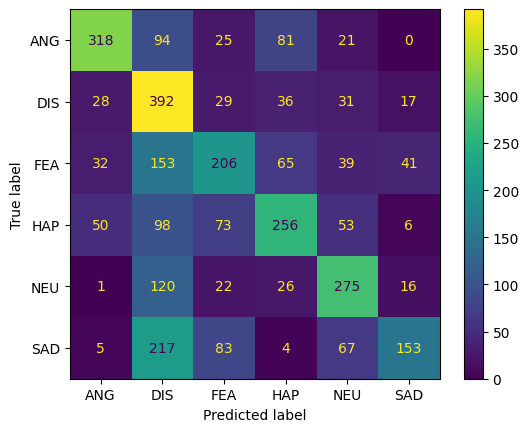

In [ ]:
cm_display_1D = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_1D, display_labels = original_labels)
cm_display_1D.plot()
plt.show()

---------------------

Run model

In [ ]:
model_ = build_1D_model(X_train_1D,X_valid_1D,y_train_1D,y_valid_1D,100,2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 1392, 128)         768       
                                                                 
 conv1d_32 (Conv1D)          (None, 1392, 64)          41024     
                                                                 
 batch_normalization_23 (Bat  (None, 1392, 64)         256       
 chNormalization)                                                
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 696, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 696, 128)          41088     
                                                                 
 conv1d_34 (Conv1D)          (None, 696, 128)        

In [ ]:
predicted_emotions_1D_ = model_.predict(X_test_1D)

98/98 [==============================] - 1s 13ms/step


In [ ]:
accuracy_1D_,f1_1D_,confusion_1D_ = calculate_accuracy(predicted_emotions_1D_, y_test_1D)

In [ ]:
print(f"test accuracy 1D: {accuracy_1D_}")
print(f"test f1_score 1D: {f1_1D_}")
print("confusion matrix for test data 1D")
print(confusion_1D_)

test accuracy 1D: 49.28183849345675
test f1_score 1D: 0.48168824442015795
confusion matrix for test data 1D
[[318 150  14  25  24   0]
 [ 21 382  10  20  53  43]
 [ 37 142 137  41  97  83]
 [ 61 163  37 143 117  12]
 [  4  91   7   9 335  19]
 [  7 155  14   2 131 229]]


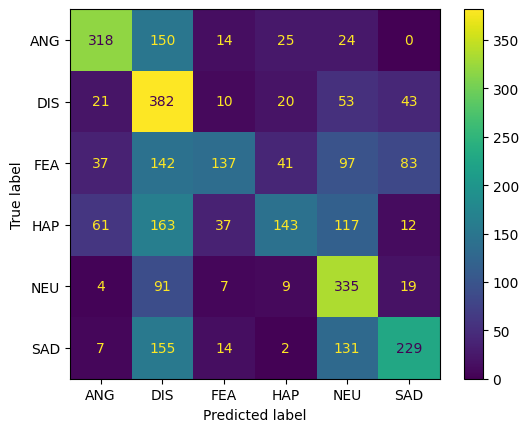

In [ ]:
cm_display_1D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_1D_, display_labels = original_labels)
cm_display_1D_.plot()
plt.show()

----------

Run model

In [ ]:
model_ = build_1D_model(X_train_1D,X_valid_1D,y_train_1D,y_valid_1D,100,2)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_31 (Conv1D)          (None, 1392, 128)         768       
                                                                 
 conv1d_32 (Conv1D)          (None, 1392, 64)          41024     
                                                                 
 batch_normalization_23 (Bat  (None, 1392, 64)         256       
 chNormalization)                                                
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 696, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_33 (Conv1D)          (None, 696, 128)          41088     
                                                                 
 conv1d_34 (Conv1D)          (None, 696, 128)        

In [ ]:
predicted_emotions_1D_ = model_.predict(X_test_1D)

98/98 [==============================] - 1s 13ms/step


In [ ]:
accuracy_1D_,f1_1D_,confusion_1D_ = calculate_accuracy(predicted_emotions_1D_, y_test_1D)

In [ ]:
print(f"test accuracy 1D: {accuracy_1D_}")
print(f"test f1_score 1D: {f1_1D_}")
print("confusion matrix for test data 1D")
print(confusion_1D_)

test accuracy 1D: 49.28183849345675
test f1_score 1D: 0.48168824442015795
confusion matrix for test data 1D
[[318 150  14  25  24   0]
 [ 21 382  10  20  53  43]
 [ 37 142 137  41  97  83]
 [ 61 163  37 143 117  12]
 [  4  91   7   9 335  19]
 [  7 155  14   2 131 229]]


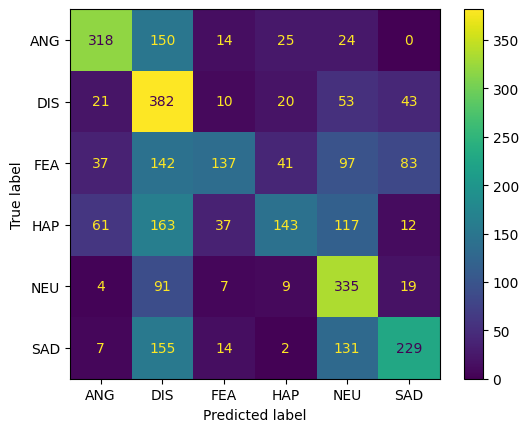

In [ ]:
cm_display_1D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_1D_, display_labels = original_labels)
cm_display_1D_.plot()
plt.show()

----------

In [ ]:
def display_random_samples_spectrogram(feature_space_2D_dataset,n) :
  random_indices = np.random.choice(len(feature_space_2D_dataset["mel_spectrogram"]),n, replace=False)
  emotions = [dataset["emotions"][i] for i in random_indices]
  mel_spectrograms = [feature_space_2D_dataset["mel_spectrogram"][i] for i in random_indices]
  for i in range(len(mel_spectrograms)):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrograms[i], sr=sampling_rate, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel Spectrogram - Emotion: {feature_space_2D_dataset['emotions'][i]}")
    plt.show()


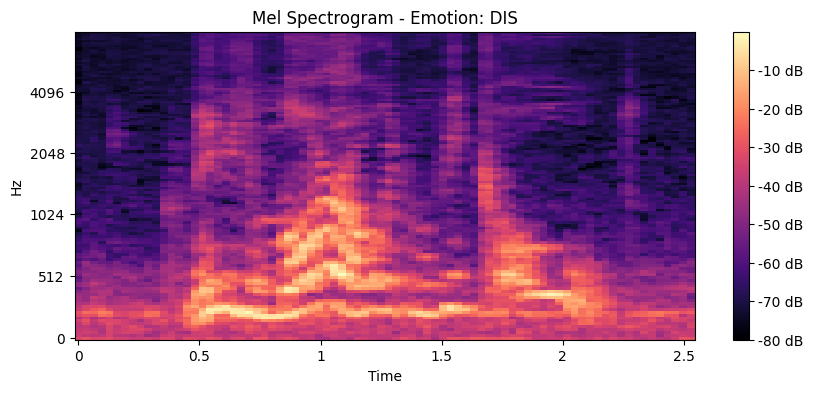

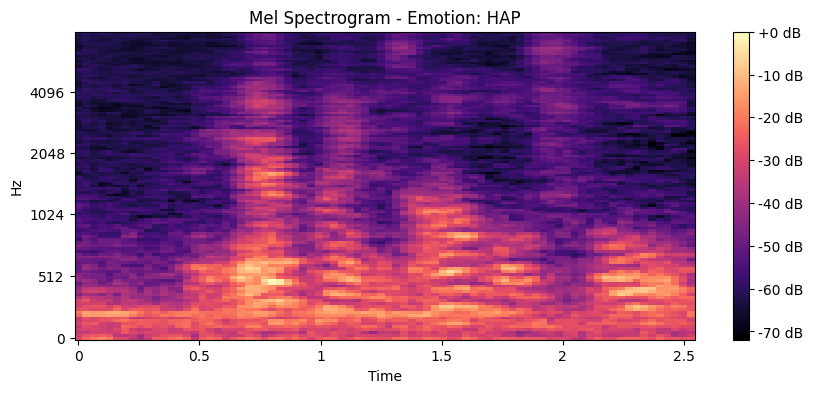

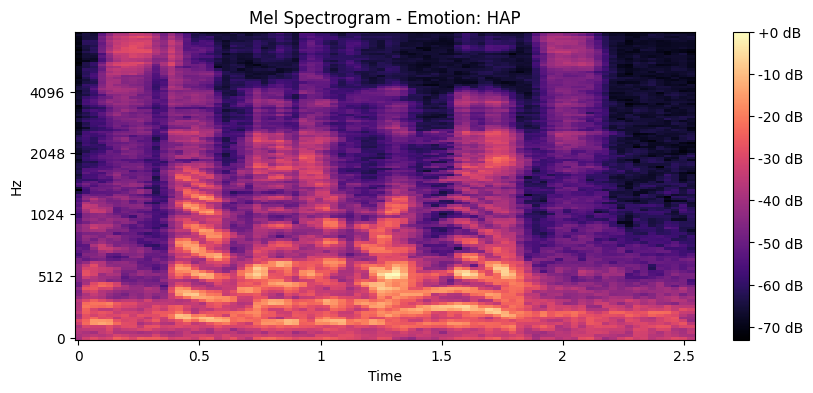

In [ ]:
display_random_samples_spectrogram(feature_space_2D_dataset,3)

In [ ]:
feature_2D = np.array(feature_space_2D_dataset["mel_spectrogram"])
X_train_2D = feature_2D[X_train,:,:]
X_valid_2D = feature_2D[X_valid,:]
X_test_2D = feature_2D[X_test,:]
y_train_2D = y_train
y_valid_2D = y_valid
y_test_2D = y_test

In [ ]:
print(X_train_2D.shape)

(6943, 128, 80)


In [ ]:
print(X_test_2D.shape)

(3133, 128, 80)


In [ ]:
def build_2D_model1(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, epochs, verbose) :
    X_train_2D = np.reshape(X_train_2D, (X_train_2D.shape[0], X_train_2D.shape[1], X_train_2D.shape[2], 1))
    input_shape_2D = X_train_2D[0].shape
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=7, activation='relu', input_shape=input_shape_2D))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3,
                            patience=5, verbose=1, mode='auto',
                            restore_best_weights=True)
    model.fit(X_train_2D, y_train_2D, epochs=epochs, verbose=verbose, validation_data=(X_valid_2D,y_valid_2D),
        callbacks=[monitor])
    return model

Run model

In [ ]:
model_2D_ = build_2D_model1(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, 80, 2)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 122, 74, 32)       1600      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 61, 37, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_21 (Bat  (None, 61, 37, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 59, 35, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 29, 17, 64)       0         
 2D)                                                             
                                                      

In [ ]:
predicted_emotions_2D_ = model_2D_.predict(X_test_2D)

98/98 [==============================] - 1s 5ms/step


In [ ]:
accuracy_2D_,f1_2D_,confusion_2D_ = calculate_accuracy(predicted_emotions_2D_,y_test_2D)

In [ ]:
print(f"test accuracy 2D: {accuracy_2D_}")
print(f"test f1_score 2D: {f1_2D_}")
print("confusion matrix for 2D test data")
print(confusion_2D_)

test accuracy 2D: 52.50558570060645
test f1_score 2D: 0.5132666027774772
confusion matrix for 2D test data
[[375  75  12  49  16   4]
 [ 48 285  13  24  55 104]
 [ 49  92 142  63  39 152]
 [ 96  87  68 195  61  26]
 [  8  67  16  20 284  70]
 [ 10  72  25   5  62 364]]


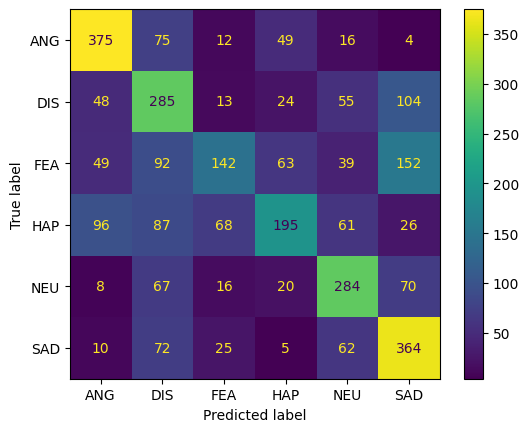

In [ ]:
cm_display_2D_ = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_2D_, display_labels = original_labels)
cm_display_2D_.plot()
plt.show()

---------------------

In [ ]:
model_2D = build_2D_model1(X_train_2D,X_valid_2D,y_train_2D,y_valid_2D, 80, 2)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 122, 74, 32)       1600      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 61, 37, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_29 (Bat  (None, 61, 37, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 59, 35, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 29, 17, 64)       0         
 g2D)                                                            
                                                     

In [ ]:
predicted_emotions_2D = model_2D.predict(X_test_2D)

98/98 [==============================] - 0s 3ms/step


In [ ]:
accuracy_2D,f1_2D,confusion_2D = calculate_accuracy(predicted_emotions_2D,y_test_2D)

In [ ]:
print(f"test accuracy 2D: {accuracy_2D}")
print(f"test f1_score 2D: {f1_2D}")
print("confusion matrix for 2D test data")
print(confusion_2D)

test accuracy 2D: 52.186402808809454
test f1_score 2D: 0.5160473379937462
confusion matrix for 2D test data
[[368  52  45  36  23   7]
 [ 32 241  64  25  39 128]
 [ 42  50 259  23  20 143]
 [ 74  70 134 159  59  37]
 [  7  68  36   8 233 113]
 [  2  49  68   8  36 375]]


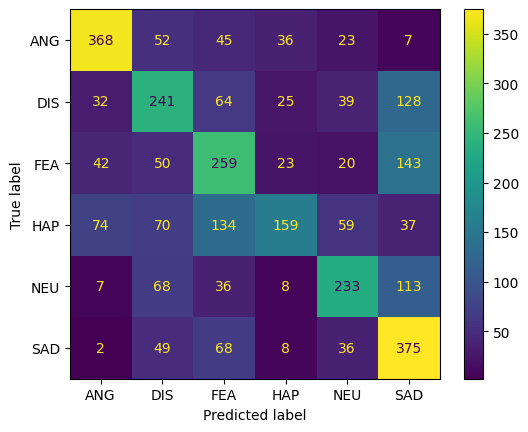

In [ ]:
cm_display_2D = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_2D, display_labels = original_labels)
cm_display_2D.plot()
plt.show()

In [6]:
measures_1D = [63.82, 50, 51.1, 50.8]
measures_1D_1 = [81.1, 54.92, 49.3, 48.2]
measures_2D = [73.28, 53.83, 52.51, 51.33]
measures_2D_1 = [92.93, 54.92, 52.17, 51.6]

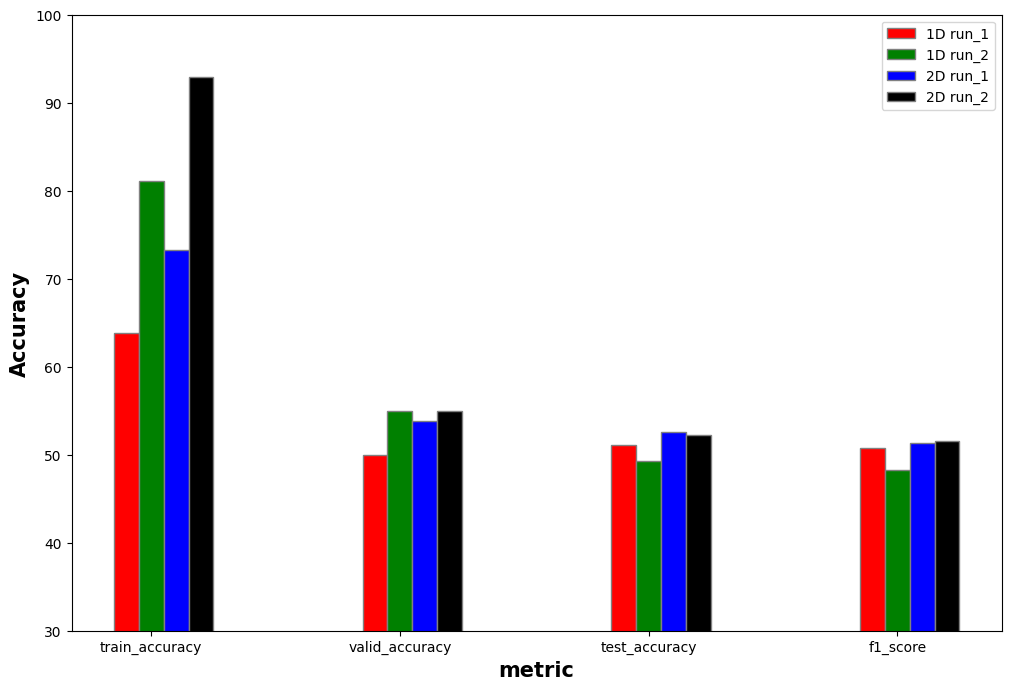

In [7]:
barWidth = 0.1
fig = plt.subplots(figsize =(12, 8))
# Set position of bar on X axis
br1 = np.arange(4)
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, measures_1D, color ='r', width = barWidth,
        edgecolor ='grey', label ='1D run_1')
plt.bar(br2, measures_1D_1, color ='g', width = barWidth,
        edgecolor ='grey', label ='1D run_2')
plt.bar(br3, measures_2D, color ='b', width = barWidth,
        edgecolor ='grey', label ='2D run_1')
plt.bar(br4, measures_2D_1, color ='k', width = barWidth,
        edgecolor ='grey', label ='2D run_2')
 
# Adding Xticks
plt.xlabel('metric', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(4)],
        ['train_accuracy', 'valid_accuracy','test_accuracy','f1_score'])
plt.ylim(30, 100)
plt.legend()
plt.show()